In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set the base path
weights_path = 'results/kdv/weights_sinpiu'
data_path = 'results/kdv/data_sinpiu'
figures_path = 'results/kdv/figures_sinpiu'

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import time

In [6]:
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

In [7]:
from koopmanlib.kdv_functions import *
from koopmanlib.functions import *

In [8]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)

# inner loop
# # Set the time sample grid.
# dt = 0.4 / (Nx**2)
T = 0.01
# Nt = int(T / dt)
# dt = T / Nt
# t = np.linspace(0, T, Nt)

In [9]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

In [10]:
umax = 1
umin = -umax

# Generate data

In [11]:
target_dim = Nx
param_dim = 3
# n_init = 1000
# traj_len = 200

In [12]:
# traj_len = 500

# n_init = 100

# seed_IC = np.random.randint(0,100,size=(n_init,))
# seed_IC

# y0_list = []
# for seed in seed_IC:
#     y0 = kdv_exact(x, seed)
#     y0_list.append(y0)
# y0_list = np.asarray(y0_list)

# y0_list.shape

# param_list_group = np.random.uniform(low=0, high=1, size=(n_init, traj_len, param_dim)) * (umax - umin) + umin

# soln_outer_list = []
# for y0, param_list in zip(y0_list, param_list_group):
#     # Calculate inner solution for each y0 and param_list (for one trajectory)
#     soln_inner_list = [y0]
#     for param in param_list:
#         # Solve the equation using the scipy integrator
#         soln = kdv_solution(y0, t, L, param, v_list)
#         y0 = soln[-1]
#         soln_inner_list.append(y0)

#     soln_inner_list = np.asarray(soln_inner_list)
    
#     soln_outer_list.append(soln_inner_list)
    
# soln_outer_list = np.asarray(soln_outer_list)

# soln_outer_list.shape

# param_list_group.shape

# data_x = soln_outer_list[:,:-1,:].reshape(-1, target_dim)
# data_y = soln_outer_list[:,1:,:].reshape(-1, target_dim)
# data_u = param_list_group.reshape(-1,param_dim)

In [13]:
# # Save the array to a CSV file
# np.savetxt('results/kdv/data/kdv_data_x.csv', data_x, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_y.csv', data_y, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_u.csv', data_u, delimiter=',')

In [14]:
# # Load the CSV file
# data_x = np.loadtxt('results/kdv/data/kdv_data_x_500.csv', delimiter=',')
# data_y = np.loadtxt('results/kdv/data/kdv_data_y_500.csv', delimiter=',')
# data_u = np.loadtxt('results/kdv/data/kdv_data_u_500.csv', delimiter=',')

In [15]:
print('load data')
X = pd.read_csv(os.path.join(data_path,'kdv_X.csv'), header=None)
Y = pd.read_csv(os.path.join(data_path,'kdv_Y.csv'), header=None)
U = pd.read_csv(os.path.join(data_path,'kdv_U.csv'), header=None)

data_x = X.values.T
data_y = Y.values.T
data_u = U.values.T

load data


# Build model

In [360]:
from koopmanlib.dictionary import PsiNN, PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [361]:
from tensorflow.keras.optimizers import Adam

In [394]:
n_psi_train = 3
# n_psi = 1 + target_dim + n_psi_train
n_psi = 1 + 1 + 1 + n_psi_train # constant + momentum + mean + NN

In [395]:
dic_pk = PsiNN_obs(layer_sizes=[16,16], n_psi_train=n_psi_train, dx=dx)

In [396]:
solver_pk = KoopmanParametricDLSolver(target_dim=target_dim, 
                                      param_dim=param_dim, 
                                      n_psi=n_psi,
                                      dic=dic_pk)

In [397]:
model_pk, model_K_u_pred_pk = solver_pk.generate_model(layer_sizes=[36,48])

In [398]:
zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

In [399]:
model_pk.compile(optimizer=Adam(0.001), loss='mse')

In [400]:
lr_callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                    factor=0.1,
                                                    patience=50,
                                                    verbose=0,
                                                    mode='auto',
                                                    min_delta=0.0001,
                                                    cooldown=0,
                                                    min_lr=1e-6)

In [401]:
history = model_pk.fit(x=[data_x, data_y, data_u], 
                    y=zeros_data_y_train, 
#                     validation_data = ([data_x_valid, data_y_valid, data_u_valid], zeros_data_y_valid),
                    epochs=700, 
                    batch_size=1024,
                    callbacks=lr_callbacks,
                    verbose=1)

Epoch 1/700
196/196 [==============================] - 2s 7ms/step - loss: 0.0654 - lr: 0.0010
Epoch 2/700
196/196 [==============================] - 1s 6ms/step - loss: 7.8965e-04 - lr: 0.0010
Epoch 3/700
196/196 [==============================] - 1s 6ms/step - loss: 3.7904e-04 - lr: 0.0010
Epoch 4/700
196/196 [==============================] - 1s 7ms/step - loss: 2.5628e-04 - lr: 0.0010
Epoch 5/700
196/196 [==============================] - 1s 7ms/step - loss: 1.9325e-04 - lr: 0.0010
Epoch 6/700
196/196 [==============================] - 1s 7ms/step - loss: 1.5494e-04 - lr: 0.0010
Epoch 7/700
196/196 [==============================] - 1s 7ms/step - loss: 1.2906e-04 - lr: 0.0010
Epoch 8/700
196/196 [==============================] - 1s 7ms/step - loss: 1.1042e-04 - lr: 0.0010
Epoch 9/700
196/196 [==============================] - 1s 6ms/step - loss: 9.5688e-05 - lr: 0.0010
Epoch 10/700
196/196 [==============================] - 1s 7ms/step - loss: 8.3738e-05 - lr: 0.0010
Epoch 11/700


196/196 [==============================] - 1s 6ms/step - loss: 1.0369e-06 - lr: 1.0000e-04
Epoch 83/700
196/196 [==============================] - 1s 6ms/step - loss: 1.0292e-06 - lr: 1.0000e-04
Epoch 84/700
196/196 [==============================] - 1s 6ms/step - loss: 1.0165e-06 - lr: 1.0000e-04
Epoch 85/700
196/196 [==============================] - 1s 6ms/step - loss: 9.9969e-07 - lr: 1.0000e-04
Epoch 86/700
196/196 [==============================] - 1s 6ms/step - loss: 9.9220e-07 - lr: 1.0000e-04
Epoch 87/700
196/196 [==============================] - 1s 6ms/step - loss: 9.7729e-07 - lr: 1.0000e-04
Epoch 88/700
196/196 [==============================] - 1s 6ms/step - loss: 9.6279e-07 - lr: 1.0000e-04
Epoch 89/700
196/196 [==============================] - 1s 6ms/step - loss: 9.5835e-07 - lr: 1.0000e-04
Epoch 90/700
196/196 [==============================] - 1s 6ms/step - loss: 9.4359e-07 - lr: 1.0000e-04
Epoch 91/700
196/196 [==============================] - 1s 6ms/step - loss: 9

196/196 [==============================] - 1s 6ms/step - loss: 5.9780e-07 - lr: 1.0000e-05
Epoch 161/700
196/196 [==============================] - 1s 6ms/step - loss: 5.9671e-07 - lr: 1.0000e-05
Epoch 162/700
196/196 [==============================] - 1s 6ms/step - loss: 5.9635e-07 - lr: 1.0000e-05
Epoch 163/700
196/196 [==============================] - 1s 5ms/step - loss: 5.9463e-07 - lr: 1.0000e-05
Epoch 164/700
196/196 [==============================] - 1s 5ms/step - loss: 5.9271e-07 - lr: 1.0000e-05
Epoch 165/700
196/196 [==============================] - 1s 6ms/step - loss: 5.8820e-07 - lr: 1.0000e-06
Epoch 166/700
196/196 [==============================] - 1s 6ms/step - loss: 5.8782e-07 - lr: 1.0000e-06
Epoch 167/700
196/196 [==============================] - 2s 8ms/step - loss: 5.8768e-07 - lr: 1.0000e-06
Epoch 168/700
196/196 [==============================] - 1s 6ms/step - loss: 5.8752e-07 - lr: 1.0000e-06
Epoch 169/700
196/196 [==============================] - 2s 8ms/step 

196/196 [==============================] - 1s 5ms/step - loss: 5.7663e-07 - lr: 1.0000e-06
Epoch 239/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7647e-07 - lr: 1.0000e-06
Epoch 240/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7636e-07 - lr: 1.0000e-06
Epoch 241/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7618e-07 - lr: 1.0000e-06
Epoch 242/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7611e-07 - lr: 1.0000e-06
Epoch 243/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7578e-07 - lr: 1.0000e-06
Epoch 244/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7571e-07 - lr: 1.0000e-06
Epoch 245/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7557e-07 - lr: 1.0000e-06
Epoch 246/700
196/196 [==============================] - 1s 5ms/step - loss: 5.7544e-07 - lr: 1.0000e-06
Epoch 247/700
196/196 [==============================] - 1s 5ms/step 

196/196 [==============================] - 2s 9ms/step - loss: 5.6479e-07 - lr: 1.0000e-06
Epoch 317/700
196/196 [==============================] - 2s 8ms/step - loss: 5.6471e-07 - lr: 1.0000e-06
Epoch 318/700
196/196 [==============================] - 2s 8ms/step - loss: 5.6457e-07 - lr: 1.0000e-06
Epoch 319/700
196/196 [==============================] - 1s 7ms/step - loss: 5.6437e-07 - lr: 1.0000e-06
Epoch 320/700
196/196 [==============================] - 1s 7ms/step - loss: 5.6431e-07 - lr: 1.0000e-06
Epoch 321/700
196/196 [==============================] - 1s 7ms/step - loss: 5.6417e-07 - lr: 1.0000e-06
Epoch 322/700
196/196 [==============================] - 1s 6ms/step - loss: 5.6402e-07 - lr: 1.0000e-06
Epoch 323/700
196/196 [==============================] - 1s 6ms/step - loss: 5.6379e-07 - lr: 1.0000e-06
Epoch 324/700
196/196 [==============================] - 1s 6ms/step - loss: 5.6371e-07 - lr: 1.0000e-06
Epoch 325/700
196/196 [==============================] - 1s 6ms/step 

196/196 [==============================] - 1s 6ms/step - loss: 5.5365e-07 - lr: 1.0000e-06
Epoch 395/700
196/196 [==============================] - 1s 6ms/step - loss: 5.5361e-07 - lr: 1.0000e-06
Epoch 396/700
196/196 [==============================] - 1s 6ms/step - loss: 5.5343e-07 - lr: 1.0000e-06
Epoch 397/700
196/196 [==============================] - 1s 5ms/step - loss: 5.5327e-07 - lr: 1.0000e-06
Epoch 398/700
196/196 [==============================] - 1s 5ms/step - loss: 5.5317e-07 - lr: 1.0000e-06
Epoch 399/700
196/196 [==============================] - 1s 5ms/step - loss: 5.5307e-07 - lr: 1.0000e-06
Epoch 400/700
196/196 [==============================] - 1s 6ms/step - loss: 5.5290e-07 - lr: 1.0000e-06
Epoch 401/700
196/196 [==============================] - 1s 6ms/step - loss: 5.5272e-07 - lr: 1.0000e-06
Epoch 402/700
196/196 [==============================] - 1s 5ms/step - loss: 5.5267e-07 - lr: 1.0000e-06
Epoch 403/700
196/196 [==============================] - 1s 6ms/step 

196/196 [==============================] - 1s 7ms/step - loss: 5.4316e-07 - lr: 1.0000e-06
Epoch 473/700
196/196 [==============================] - 1s 6ms/step - loss: 5.4308e-07 - lr: 1.0000e-06
Epoch 474/700
196/196 [==============================] - 1s 7ms/step - loss: 5.4288e-07 - lr: 1.0000e-06
Epoch 475/700
196/196 [==============================] - 1s 6ms/step - loss: 5.4285e-07 - lr: 1.0000e-06
Epoch 476/700
196/196 [==============================] - 1s 6ms/step - loss: 5.4267e-07 - lr: 1.0000e-06
Epoch 477/700
196/196 [==============================] - 1s 5ms/step - loss: 5.4255e-07 - lr: 1.0000e-06
Epoch 478/700
196/196 [==============================] - 1s 5ms/step - loss: 5.4232e-07 - lr: 1.0000e-06
Epoch 479/700
196/196 [==============================] - 1s 5ms/step - loss: 5.4224e-07 - lr: 1.0000e-06
Epoch 480/700
196/196 [==============================] - 1s 5ms/step - loss: 5.4217e-07 - lr: 1.0000e-06
Epoch 481/700
196/196 [==============================] - 1s 5ms/step 

196/196 [==============================] - 1s 6ms/step - loss: 5.3331e-07 - lr: 1.0000e-06
Epoch 551/700
196/196 [==============================] - 1s 6ms/step - loss: 5.3312e-07 - lr: 1.0000e-06
Epoch 552/700
196/196 [==============================] - 1s 5ms/step - loss: 5.3297e-07 - lr: 1.0000e-06
Epoch 553/700
196/196 [==============================] - 1s 5ms/step - loss: 5.3289e-07 - lr: 1.0000e-06
Epoch 554/700
196/196 [==============================] - 1s 6ms/step - loss: 5.3275e-07 - lr: 1.0000e-06
Epoch 555/700
196/196 [==============================] - 1s 6ms/step - loss: 5.3262e-07 - lr: 1.0000e-06
Epoch 556/700
196/196 [==============================] - 1s 6ms/step - loss: 5.3258e-07 - lr: 1.0000e-06
Epoch 557/700
196/196 [==============================] - 1s 7ms/step - loss: 5.3245e-07 - lr: 1.0000e-06
Epoch 558/700
196/196 [==============================] - 1s 6ms/step - loss: 5.3228e-07 - lr: 1.0000e-06
Epoch 559/700
196/196 [==============================] - 1s 6ms/step 

196/196 [==============================] - 1s 6ms/step - loss: 5.2387e-07 - lr: 1.0000e-06
Epoch 629/700
196/196 [==============================] - 1s 7ms/step - loss: 5.2382e-07 - lr: 1.0000e-06
Epoch 630/700
196/196 [==============================] - 1s 6ms/step - loss: 5.2373e-07 - lr: 1.0000e-06
Epoch 631/700
196/196 [==============================] - 1s 6ms/step - loss: 5.2365e-07 - lr: 1.0000e-06
Epoch 632/700
196/196 [==============================] - 1s 6ms/step - loss: 5.2342e-07 - lr: 1.0000e-06
Epoch 633/700
196/196 [==============================] - 1s 7ms/step - loss: 5.2332e-07 - lr: 1.0000e-06
Epoch 634/700
196/196 [==============================] - 1s 7ms/step - loss: 5.2320e-07 - lr: 1.0000e-06
Epoch 635/700
196/196 [==============================] - 1s 6ms/step - loss: 5.2312e-07 - lr: 1.0000e-06
Epoch 636/700
196/196 [==============================] - 1s 6ms/step - loss: 5.2297e-07 - lr: 1.0000e-06
Epoch 637/700
196/196 [==============================] - 1s 6ms/step 

In [333]:
# model_pk.save_weights(os.path.join(weights_path,'pk_kdv_mass_momentum_weights_psi3_klayer48.h5'))

In [354]:
# model_pk.load_weights(os.path.join(weights_path,'pk_kdv_mass_momentum_weights_psi3_klayer48.h5'))

# Prediction

In [31]:
def compute_pk_obs(y0, param_list, B_obs):
    param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1,-1)
    
    psi_y = dic_pk(y0)
    obs_list = [psi_y@B_obs]
    
    tau = param_list.shape[0]

    for i in range(tau):
        psi_y = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_y@B_obs
        obs_list.append(obs_next)
        
    return np.squeeze(np.asarray(obs_list))

In [32]:
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv_solution(y0_loop, T, L, param, v_list, x)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [33]:
pred_traj_number = 5
np.random.seed(625)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number,2))

y0_pred_list=[]
param_pred_list = []

Tsim_pred = 0.05
traj_len_pred = int(Tsim_pred / T)

for seed_x, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv_exact(x, seed=seed_x) 
    

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    
    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)



In [29]:
error_mass_list_pk, error_momentum_list_pk = compute_obs_error(dic=dic_pk,
                                                           compute_kdv_soln_func=compute_kdv_soln,
                                                           compute_obs_func_model=compute_pk_obs,
                                                           error_func=compute_diff_ratio_one_traj,
                                                           y0_pred_list=y0_pred_list,
                                                           param_pred_list=param_pred_list,
                                                           dx=dx)

In [30]:
mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(error_mass_list_pk)
momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = compute_stat_info(error_momentum_list_pk)

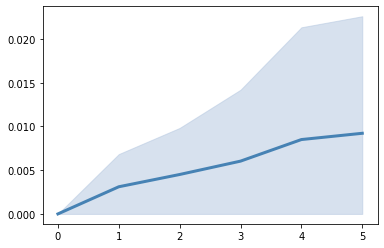

In [31]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.plot(mass_mean_pk, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(mass_mean_minus_pk,0), mass_mean_plus_pk, color='lightsteelblue', alpha=0.5)

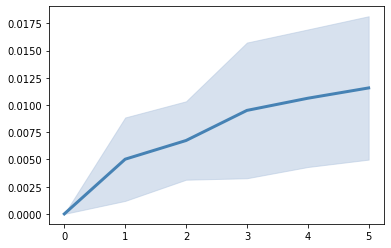

In [32]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.plot(momentum_mean_pk, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(momentum_mean_minus_pk,0), momentum_mean_plus_pk, color='lightsteelblue', alpha=0.5)

In [70]:
mass_dict_error_pk = {'mean': mass_mean_pk,
             'std': mass_std_pk,
             'mean_plus':mass_mean_plus_pk,
             'mean_minus':mass_mean_minus_pk}
np.save(os.path.join(data_path,'mass_error_pk.npy'), mass_dict_error_pk)


momentum_dict_error_pk = {'mean': momentum_mean_pk,
             'std': momentum_std_pk,
             'mean_plus':momentum_mean_plus_pk,
             'mean_minus':momentum_mean_minus_pk}
np.save(os.path.join(data_path,'momentum_error_pk.npy'), momentum_dict_error_pk)

# Tracking problem

In [84]:
from scipy.optimize import minimize

In [85]:
# Testing reference

y0_track = np.zeros(shape=(Nx, )) + 0.2

In [86]:
# y0_track = kdv_exact(x, seed=10)

In [87]:
Tpred_track = 0.02
Tsim_track = 10

traj_len_track = int(Tsim_track / T)
Np = int(Tpred_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track+Np, target_dim))+0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5

In [88]:
tau = Np - 1

In [89]:
soln_ref = np.loadtxt(os.path.join(data_path,'track_soln_ref'), delimiter=',')

In [90]:
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1,1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1,1))

In [91]:
0.3 * 128 *dx

1.8997977621708355

In [92]:
mass_ref

<tf.Tensor: shape=(1002, 1), dtype=float64, numpy=
array([[1.89979776],
       [1.89979776],
       [1.89979776],
       ...,
       [3.1663296 ],
       [3.1663296 ],
       [3.1663296 ]])>

In [93]:
momentum_ref

<tf.Tensor: shape=(1002, 1), dtype=float64, numpy=
array([[0.56993933],
       [0.56993933],
       [0.56993933],
       ...,
       [1.5831648 ],
       [1.5831648 ],
       [1.5831648 ]])>

In [240]:
def mpc_loss_pk(param, tau, ref_list, y0, B):
    param = tf.reshape(param, shape=(int(param.shape[0]/param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1,-1)
    psi_y = dic_pk(y0)
    
    for i in range(tau):
        psi_x = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_x@B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)
    
    ref_loss= tf.reduce_sum(loss_list)
    param_loss = 0.005 * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))
    
    loss = ref_loss + param_loss
    
#     loss = ref_loss
    return loss   

In [241]:
def KoopmanMPC(y0, traj_len, soln_ref, kdv_solver, B, loss):
    
    bounds= []
    for i in range(tau*param_dim):
        bounds.append((-1,1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []
    for current_time in range(traj_len):
        print('current time step: ', current_time)
        start_time = time.time()
        # This needs param_init is a scalor

        param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

        results = minimize(loss, 
                       x0=param_init,
                       args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
                       bounds=bounds)

        param = results.x.reshape(tau, param_dim)[0]
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param, v_list, x)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)
        end_time = time.time()

        print('loss: ', results.fun)
        
    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)
    
    return opt_control_list, y0_mpc_loop_list

# Inverse Problem

In [402]:
B_mass = dic_pk.generate_B_mass(mass_ref)
B_momentum = dic_pk.generate_B_momentum(momentum_ref)

## Track mass

In [403]:
pk_opt_control_mass, pk_kdv_opt_mass_soln = KoopmanMPC(y0=y0_track,
                                                traj_len=traj_len_track,
                                                soln_ref=mass_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_mass,
                                                loss=mpc_loss_pk)

current time step:  0
loss:  0.3926988657719592
current time step:  1
loss:  0.3799028419065732
current time step:  2
loss:  0.3672975514944529
current time step:  3
loss:  0.36240447115731345
current time step:  4
loss:  0.34671059767503076
current time step:  5
loss:  0.3347576575284236
current time step:  6
loss:  0.3304701650195779
current time step:  7
loss:  0.31528383235425367
current time step:  8
loss:  0.30392866576030186
current time step:  9
loss:  0.29280281657754403
current time step:  10
loss:  0.2819051345753068
current time step:  11
loss:  0.27124802956617017
current time step:  12
loss:  0.2608399295098137
current time step:  13
loss:  0.2506750144210551
current time step:  14
loss:  0.24073646917307423
current time step:  15
loss:  0.23101314657564057
current time step:  16
loss:  0.22769186079637793
current time step:  17
loss:  0.21520953751572597
current time step:  18
loss:  0.2060934162189963
current time step:  19
loss:  0.19721162044641882
current time step: 

loss:  1.7484030172255325e-07
current time step:  160
loss:  1.795549870793729e-07
current time step:  161
loss:  1.9264561014128214e-07
current time step:  162
loss:  1.8974732672864496e-07
current time step:  163
loss:  1.574845068227716e-07
current time step:  164
loss:  1.221134832812983e-07
current time step:  165
loss:  9.770697402514233e-08
current time step:  166
loss:  1.0614467683379516e-07
current time step:  167
loss:  1.27183055377674e-07
current time step:  168
loss:  1.5587333169443882e-07
current time step:  169
loss:  1.4114225932990154e-07
current time step:  170
loss:  1.016807893665976e-07
current time step:  171
loss:  6.49127889992529e-08
current time step:  172
loss:  4.854155919424013e-08
current time step:  173
loss:  6.790550303673877e-08
current time step:  174
loss:  7.500908034964884e-08
current time step:  175
loss:  9.100193815900151e-08
current time step:  176
loss:  7.35273964239477e-08
current time step:  177
loss:  5.1826207148651755e-08
current time 

loss:  1.2687352371795463e-09
current time step:  314
loss:  1.0837649864197901e-09
current time step:  315
loss:  7.168217984921979e-10
current time step:  316
loss:  1.6142926744401477e-09
current time step:  317
loss:  6.375914820656969e-09
current time step:  318
loss:  9.611245658988448e-09
current time step:  319
loss:  4.957710043950684e-09
current time step:  320
loss:  3.025148900154127e-09
current time step:  321
loss:  5.228120911953456e-09
current time step:  322
loss:  4.32040714340326e-10
current time step:  323
loss:  5.100114221825823e-09
current time step:  324
loss:  3.669161311347824e-09
current time step:  325
loss:  1.629897670015161e-09
current time step:  326
loss:  5.086949644857449e-10
current time step:  327
loss:  1.0021510921479546e-09
current time step:  328
loss:  4.3165106835326946e-09
current time step:  329
loss:  1.8042749250207551e-09
current time step:  330
loss:  7.920942963774952e-10
current time step:  331
loss:  1.5013958548397694e-09
current tim

loss:  3.653771268351719e-09
current time step:  468
loss:  3.740008059244863e-09
current time step:  469
loss:  1.9054913186581057e-09
current time step:  470
loss:  1.2385637803791639e-09
current time step:  471
loss:  5.4974450643391014e-09
current time step:  472
loss:  2.8014868334058605e-09
current time step:  473
loss:  8.055555772965147e-10
current time step:  474
loss:  4.545851459110661e-10
current time step:  475
loss:  3.363934275977188e-09
current time step:  476
loss:  2.9474271930213646e-09
current time step:  477
loss:  3.516665030333658e-09
current time step:  478
loss:  2.3463574750054513e-09
current time step:  479
loss:  6.374106272184275e-09
current time step:  480
loss:  3.4234539696161573e-10
current time step:  481
loss:  2.1689547566935103e-09
current time step:  482
loss:  2.947166340177603e-09
current time step:  483
loss:  1.4089445684644542e-09
current time step:  484
loss:  5.694705654379328e-11
current time step:  485
loss:  1.3835212873769873e-09
current

loss:  0.019416752372732694
current time step:  629
loss:  0.017682446980772062
current time step:  630
loss:  0.01605562649579507
current time step:  631
loss:  0.014544409375935097
current time step:  632
loss:  0.013148276533648947
current time step:  633
loss:  0.011869538453228431
current time step:  634
loss:  0.010710306313266534
current time step:  635
loss:  0.009621696839189394
current time step:  636
loss:  0.008647417095598702
current time step:  637
loss:  0.00775302522043459
current time step:  638
loss:  0.006961439473352133
current time step:  639
loss:  0.006239584002994969
current time step:  640
loss:  0.005592595487042339
current time step:  641
loss:  0.004983990502513751
current time step:  642
loss:  0.004446448711436534
current time step:  643
loss:  0.00396456054813532
current time step:  644
loss:  0.0035256947624572213
current time step:  645
loss:  0.0031342970574862647
current time step:  646
loss:  0.0027736450484791716
current time step:  647
loss:  0.002

loss:  8.963961616987157e-09
current time step:  784
loss:  5.897936868147105e-09
current time step:  785
loss:  1.2631294265460407e-08
current time step:  786
loss:  6.483171766579383e-10
current time step:  787
loss:  5.093242061172926e-10
current time step:  788
loss:  2.3063193578656697e-08
current time step:  789
loss:  1.6178757730906438e-08
current time step:  790
loss:  2.3053879694597143e-08
current time step:  791
loss:  1.7605786203408675e-09
current time step:  792
loss:  4.6815801147011025e-09
current time step:  793
loss:  6.291001416448457e-09
current time step:  794
loss:  1.1409676297257693e-08
current time step:  795
loss:  1.1232795566427419e-08
current time step:  796
loss:  1.9439320315560737e-08
current time step:  797
loss:  1.2798830215225518e-09
current time step:  798
loss:  2.19149230026694e-10
current time step:  799
loss:  3.274872586489862e-08
current time step:  800
loss:  1.052269523004174e-08
current time step:  801
loss:  2.2190542979774858e-08
current

loss:  3.936881884619342e-09
current time step:  938
loss:  7.3853363901787e-09
current time step:  939
loss:  4.665223741168716e-08
current time step:  940
loss:  3.261049178656533e-08
current time step:  941
loss:  4.717763069312242e-09
current time step:  942
loss:  6.189801511135155e-11
current time step:  943
loss:  2.7553779588779903e-08
current time step:  944
loss:  8.226066544547504e-09
current time step:  945
loss:  1.8469751469970033e-08
current time step:  946
loss:  1.04254622821952e-09
current time step:  947
loss:  1.8151001628821615e-08
current time step:  948
loss:  1.8304581503551088e-08
current time step:  949
loss:  1.0052976106028555e-08
current time step:  950
loss:  4.947993882881373e-08
current time step:  951
loss:  1.995284866587158e-08
current time step:  952
loss:  3.1824298716672733e-10
current time step:  953
loss:  3.771785859655533e-09
current time step:  954
loss:  2.2611565439668732e-09
current time step:  955
loss:  1.0060235367287172e-08
current time

In [404]:
np.savetxt(os.path.join(data_path,'penalty_pk_mass_kdv_opt_control_20s_greedy_klayer48.csv'), pk_opt_control_mass, delimiter=',')
np.savetxt(os.path.join(data_path,'penalty_pk_mass_kdv_opt_soln_20s_greedy_klayer48.csv'), pk_kdv_opt_mass_soln, delimiter=',')

In [405]:
# pk_opt_control_mass = np.loadtxt(os.path.join(data_path,'no_penalty_pk_mass_kdv_opt_control_20s_greedy.csv'), delimiter=',')
# pk_kdv_opt_mass_soln = np.loadtxt(os.path.join(data_path,'no_penalty_pk_mass_kdv_opt_soln_20s_greedy.csv'), delimiter=',')

In [406]:
pk_kdv_opt_mass = dx * tf.reduce_sum(pk_kdv_opt_mass_soln, axis=-1)

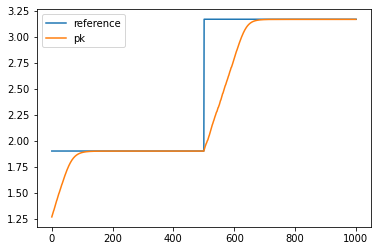

In [407]:
plt.plot(mass_ref, label='reference')
plt.plot(pk_kdv_opt_mass, label='pk')
plt.legend()

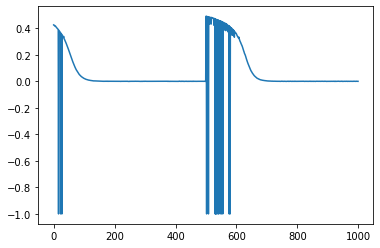

In [408]:
plt.plot(pk_opt_control_mass[:,0])

## Track momentum

In [409]:
pk_opt_control_momentum, pk_kdv_opt_momentum_soln = KoopmanMPC(y0=y0_track,
                                                traj_len=traj_len_track,
                                                soln_ref=momentum_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_momentum,
                                                loss=mpc_loss_pk)

current time step:  0
loss:  0.09914457182590077
current time step:  1
loss:  0.09733189780837852
current time step:  2
loss:  0.09551704968259664
current time step:  3
loss:  0.09370626295737235
current time step:  4
loss:  0.09190847859133564
current time step:  5
loss:  0.0901293076121177
current time step:  6
loss:  0.08836879203086756
current time step:  7
loss:  0.08662964351609885
current time step:  8
loss:  0.08490652768981712
current time step:  9
loss:  0.08319194223846436
current time step:  10
loss:  0.08147797745805288
current time step:  11
loss:  0.07976303507613872
current time step:  12
loss:  0.07805122821044623
current time step:  13
loss:  0.0763530189067685
current time step:  14
loss:  0.07467830153098058
current time step:  15
loss:  0.07302876653345101
current time step:  16
loss:  0.07140514302359494
current time step:  17
loss:  0.0698050531588151
current time step:  18
loss:  0.06822042518453586
current time step:  19
loss:  0.06665072046024617
current time 

loss:  0.00013432282354562151
current time step:  160
loss:  0.00012712363536236722
current time step:  161
loss:  0.00012029342013993213
current time step:  162
loss:  0.00011375997887302747
current time step:  163
loss:  0.00010756490303849152
current time step:  164
loss:  0.00010169210082835069
current time step:  165
loss:  9.616300859358704e-05
current time step:  166
loss:  9.097645989791622e-05
current time step:  167
loss:  8.611060121272578e-05
current time step:  168
loss:  8.148932583363185e-05
current time step:  169
loss:  7.709539715561481e-05
current time step:  170
loss:  7.29857355717508e-05
current time step:  171
loss:  6.89301656725663e-05
current time step:  172
loss:  6.539371317758901e-05
current time step:  173
loss:  6.162256634761677e-05
current time step:  174
loss:  5.840732679221769e-05
current time step:  175
loss:  5.524189949963579e-05
current time step:  176
loss:  5.23636880072293e-05
current time step:  177
loss:  4.950192957224279e-05
current time s

loss:  5.927408419501935e-08
current time step:  314
loss:  5.620517897560917e-08
current time step:  315
loss:  5.4908216275331164e-08
current time step:  316
loss:  5.314665302753962e-08
current time step:  317
loss:  5.2364464812917525e-08
current time step:  318
loss:  5.1470423140174016e-08
current time step:  319
loss:  4.5037458952196034e-08
current time step:  320
loss:  4.777038713524733e-08
current time step:  321
loss:  4.515455914043919e-08
current time step:  322
loss:  4.4488156612688475e-08
current time step:  323
loss:  4.304687874010404e-08
current time step:  324
loss:  3.9329325610875505e-08
current time step:  325
loss:  3.757807003134355e-08
current time step:  326
loss:  3.521542728351523e-08
current time step:  327
loss:  3.5515791028730896e-08
current time step:  328
loss:  2.8476596916570916e-08
current time step:  329
loss:  2.6860949069415275e-08
current time step:  330
loss:  2.5895826388942663e-08
current time step:  331
loss:  2.8241818817797166e-08
curren

loss:  2.907169577021406e-09
current time step:  468
loss:  7.1410461316929e-09
current time step:  469
loss:  4.1707944397689e-09
current time step:  470
loss:  3.914657172205113e-09
current time step:  471
loss:  8.343056263040257e-10
current time step:  472
loss:  3.771841195598174e-10
current time step:  473
loss:  7.829649356192534e-10
current time step:  474
loss:  5.219098456010097e-10
current time step:  475
loss:  5.806724273480034e-10
current time step:  476
loss:  4.807890447521739e-10
current time step:  477
loss:  3.371650056799129e-09
current time step:  478
loss:  8.258234101109722e-10
current time step:  479
loss:  3.148620037136441e-09
current time step:  480
loss:  4.883174820056166e-10
current time step:  481
loss:  2.6472886802341207e-10
current time step:  482
loss:  3.670375777364075e-10
current time step:  483
loss:  2.2687601249525247e-10
current time step:  484
loss:  4.298083565356589e-09
current time step:  485
loss:  2.3429752344261564e-09
current time step:

loss:  0.03312366357676334
current time step:  629
loss:  0.030585513039769578
current time step:  630
loss:  0.02815795460452732
current time step:  631
loss:  0.025861815118536257
current time step:  632
loss:  0.023648385415740724
current time step:  633
loss:  0.021560116185103596
current time step:  634
loss:  0.019585834244332984
current time step:  635
loss:  0.017749311354715847
current time step:  636
loss:  0.01606230187340366
current time step:  637
loss:  0.014511023157277116
current time step:  638
loss:  0.013111342227654355
current time step:  639
loss:  0.01182263278579627
current time step:  640
loss:  0.010650397523153811
current time step:  641
loss:  0.009553881639346042
current time step:  642
loss:  0.008548649613814569
current time step:  643
loss:  0.007612110678255712
current time step:  644
loss:  0.006759923168373176
current time step:  645
loss:  0.0059877480523979594
current time step:  646
loss:  0.005299011942251044
current time step:  647
loss:  0.004686

loss:  8.887967485829692e-10
current time step:  784
loss:  3.08572419568198e-10
current time step:  785
loss:  2.782314363810529e-10
current time step:  786
loss:  2.113738447276737e-09
current time step:  787
loss:  1.0508851713301458e-09
current time step:  788
loss:  4.6210363369205545e-10
current time step:  789
loss:  1.2481914136766744e-09
current time step:  790
loss:  5.778331688886505e-10
current time step:  791
loss:  3.4303843834689068e-09
current time step:  792
loss:  6.535002918771296e-11
current time step:  793
loss:  3.1569182751475276e-10
current time step:  794
loss:  3.388779968908835e-11
current time step:  795
loss:  8.765815545804018e-10
current time step:  796
loss:  1.0368864415706942e-09
current time step:  797
loss:  1.0998335953278966e-09
current time step:  798
loss:  4.429471238146876e-11
current time step:  799
loss:  1.6008106217634667e-12
current time step:  800
loss:  8.792460924712134e-11
current time step:  801
loss:  2.005471153611641e-10
current ti

loss:  7.505561833068498e-09
current time step:  938
loss:  3.754074049739472e-10
current time step:  939
loss:  5.756647820608444e-10
current time step:  940
loss:  2.0936266798170447e-10
current time step:  941
loss:  5.826644793937792e-10
current time step:  942
loss:  2.501471827373201e-10
current time step:  943
loss:  3.9276964161158537e-10
current time step:  944
loss:  4.964269128749132e-10
current time step:  945
loss:  7.491724993638023e-10
current time step:  946
loss:  6.316573268592788e-10
current time step:  947
loss:  5.32619978700168e-10
current time step:  948
loss:  7.691822914118425e-10
current time step:  949
loss:  5.275247145532065e-10
current time step:  950
loss:  5.952523349089921e-10
current time step:  951
loss:  1.4680204295877463e-10
current time step:  952
loss:  3.299388635908128e-10
current time step:  953
loss:  6.563809192969301e-09
current time step:  954
loss:  3.08152465810256e-10
current time step:  955
loss:  6.875052473798533e-11
current time ste

In [410]:
pk_kdv_opt_momentum = dx * tf.reshape(tf.math.reduce_sum(tf.square(pk_kdv_opt_momentum_soln), axis=-1), shape=(-1,1))

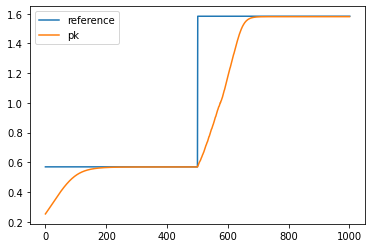

In [411]:
plt.plot(momentum_ref, label='reference')
plt.plot(pk_kdv_opt_momentum, label='pk')
plt.legend()

In [412]:
np.savetxt(os.path.join(data_path,'penalty_pk_momentum_kdv_opt_control_20s_greedy_klayer48.csv'), pk_opt_control_momentum, delimiter=',')
np.savetxt(os.path.join(data_path,'penalty_pk_momentum_kdv_opt_soln_20s_greedy_klayer48.csv'), pk_kdv_opt_momentum_soln, delimiter=',')

# Controllability

In [413]:
# Randomly sample control
np.random.seed(seed=111)
n_control_samples = 2000
control_samples = np.random.uniform(low=0, high=1, size=(n_control_samples, param_dim)) * (umax - umin) + umin

In [414]:
pk_K_matrix = solver_pk.model_K_u(control_samples)

In [415]:
pk_K_matrix.shape

TensorShape([2000, 6, 6])

In [416]:
identity_matrix = np.eye(N=pk_K_matrix.shape[-1])

pk_A_matrix = (pk_K_matrix - identity_matrix) / T

pk_A_vector = tf.reshape(pk_A_matrix, shape=(pk_A_matrix.shape[0], pk_A_matrix.shape[-1]*pk_A_matrix.shape[-1]))

rank = np.linalg.matrix_rank(pk_A_vector)

U, S, VT = np.linalg.svd(pk_A_vector)

In [417]:
pk_A_vector.shape

TensorShape([2000, 36])

In [418]:
np.sum(S > 1e-5)

36

In [419]:
S

array([6.01178196e+03, 7.97919288e+02, 5.26798529e+02, 3.35942311e+02,
       1.26093293e+01, 9.81249818e+00, 9.05123785e+00, 7.30370195e+00,
       6.17060053e+00, 4.87303170e+00, 4.13221629e+00, 3.48987258e+00,
       3.00960458e+00, 1.93834228e+00, 1.77041704e+00, 1.56421913e+00,
       1.46553569e+00, 9.04419293e-01, 8.28709567e-01, 6.45788936e-01,
       1.44379701e-01, 9.95442644e-02, 7.05602720e-02, 4.55569976e-02,
       3.75252741e-02, 2.76743031e-02, 2.44098751e-02, 2.19055417e-02,
       1.82901048e-02, 1.48045527e-02, 1.32756837e-02, 1.27028425e-02,
       9.67789795e-03, 7.29340259e-03, 4.98238993e-03, 4.05129500e-03])

In [420]:
label_font = 16
ticks_font = 16

In [421]:
np.linspace(1,36,8)

array([ 1.,  6., 11., 16., 21., 26., 31., 36.])

In [422]:
np.savetxt(os.path.join(data_path,'pk_eigenvalue_klayer48.csv'), S, delimiter=',')

Text(0, 0.5, '$\\sigma_{i}$')

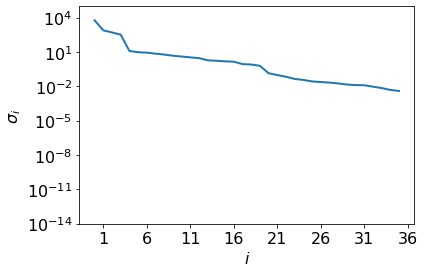

In [423]:
plt.plot(S, linewidth=2)
plt.yscale('log')

custom_xticks = np.linspace(1,36,8)
plt.xticks(custom_xticks, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

# plt.xlim(0,37) 
plt.ylim(1e-14,1e5) 
plt.xlabel(r'$i$', fontsize=label_font)
plt.ylabel(r'$\sigma_{i}$', fontsize=label_font)

# plt.savefig(os.path.join(figures_path, 'pk_eigenvalue_klayer12.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'pk_eigenvalue_klayer12.pdf'), dpi=200, bbox_inches='tight')

# Check exact control

In [197]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

In [198]:
x

array([-3.14159265, -3.09211875, -3.04264485, -2.99317095, -2.94369705,
       -2.89422315, -2.84474925, -2.79527535, -2.74580145, -2.69632755,
       -2.64685365, -2.59737975, -2.54790585, -2.49843195, -2.44895805,
       -2.39948415, -2.35001025, -2.30053635, -2.25106245, -2.20158855,
       -2.15211465, -2.10264075, -2.05316685, -2.00369295, -1.95421905,
       -1.90474515, -1.85527125, -1.80579735, -1.75632345, -1.70684955,
       -1.65737565, -1.60790175, -1.55842785, -1.50895395, -1.45948005,
       -1.41000615, -1.36053225, -1.31105835, -1.26158445, -1.21211055,
       -1.16263665, -1.11316275, -1.06368885, -1.01421495, -0.96474105,
       -0.91526715, -0.86579325, -0.81631935, -0.76684545, -0.71737155,
       -0.66789765, -0.61842375, -0.56894985, -0.51947595, -0.47000205,
       -0.42052815, -0.37105425, -0.32158035, -0.27210645, -0.22263255,
       -0.17315865, -0.12368475, -0.07421085, -0.02473695,  0.02473695,
        0.07421085,  0.12368475,  0.17315865,  0.22263255,  0.27

In [199]:
def v1_func(x):
    return np.exp(-25 * (x + np.pi/2)**2)

def v2_func(x):
    return np.exp(-25 * (x)**2)

def v3_func(x):
    return np.exp(-25 * (x - np.pi/2)**2)

In [200]:
from scipy import integrate

In [201]:
integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi) 

In [202]:
integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi) 

In [203]:
integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi) 

In [205]:
rhs_value = integral_1 + integral_2 + integral_3

In [206]:
rhs_value

1.06347231054331

In [190]:
mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1,1))

In [191]:
mass_y0_track

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.26653184]])>

In [194]:
dx * tf.reshape(tf.math.reduce_sum(tf.square(y0_track), axis=-1), shape=(-1,1))

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.25330637]])>

In [192]:
track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T) 

NameError: name 'rhs_value' is not defined

In [193]:
mass_y0_track

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.26653184]])>

In [760]:
track_step_1 

59

In [761]:
track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

In [762]:
track_step_2

119

In [763]:
control_exact_opt = np.zeros(shape= pk_opt_control_mass.shape, dtype='float64')

In [764]:
control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500:500+track_step_2] = 0.5

In [765]:
# kdv_opt_control = compute_kdv_soln(y0_track, pk_opt_control_mass)
kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)

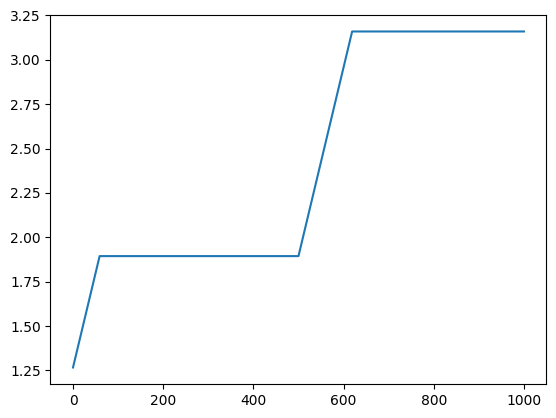

In [766]:
kdv_mass_opt_control = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1,1))

plt.plot(kdv_mass_opt_control)

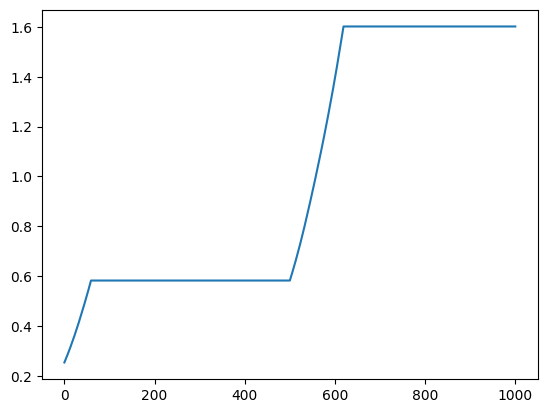

In [767]:
kdv_momentum_opt_control = dx * tf.reshape(tf.math.reduce_sum(tf.square(kdv_opt_control), axis=-1), shape=(-1,1))

plt.plot(kdv_momentum_opt_control)

In [768]:
np.savetxt(os.path.join(data_path,'exact_soln_kdv_opt_control_20s_greedy.csv'), control_exact_opt, delimiter=',')
np.savetxt(os.path.join(data_path,'exact_soln_kdv_opt_soln_20s_greedy.csv'), kdv_opt_control, delimiter=',')